In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%run fix_paths.ipy

Populating the interactive namespace from numpy and matplotlib
/workspace/srp-boxes


In [366]:
C.INT_DATA

'/workspace/srp-boxes/data/interim'

In [ ]:
pos_top = os.path.join(C.INT_DATA, 'srp/samples/pos')
pospickels = glob.glob(os.path.join(top, "*/*/*.pickle"))

In [ ]:
import glob
import pickle
def make_next_batch_variations(number_of_variations=20):
    top = os.path.join(C.INT_DATA, "srp/samples")
    origs = glob.glob(os.path.join(top, "*/*/*_orig.pickle"), recursive=False)
    for origd in origs:
        with open(origd, 'rb') as handle:
            p = pickle.load(handle)
            for i in range(number_of_variations):
                var = augment(p, radius=C.PATCH_SIZE/2)
                with open(origd.replace("orig", "var{0:02d}".format(i+1)), 'wb') as handle:
                    pickle.dump(var, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [263]:
from collections import namedtuple
Patch = namedtuple("Patch",["obb", "volumetric", "rgb", "label","ori_xy"])

In [293]:
from skimage.transform import rotate

def _augment(p, radius):
    dr = int(np.random.uniform(-1,1) * C.MAX_OFFSET)
    dc = int(np.random.uniform(-1,1) * C.MAX_OFFSET)
    rotate_angle = np.random.rand() * 360
    p_center = int(p.volumetric.shape[1]/2)
    
    source_patch = np.concatenate((p.rgb, p.volumetric))
    rotated_patch = np.zeros((source_patch.shape))
    
    for i in range(len(source_patch)):
        rotated_patch[i] = rotate(source_patch[i], rotate_angle, preserve_range=True)
    
    
        cropped_patch = rotated_patch[:, 
                                      p_center-radius+dc: p_center+radius+dc, 
                                      p_center-radius-dr: p_center+radius-dr]      # is this dc dr here?
        rgb = cropped_patch[:3]
        volumetric = cropped_patch[3:]
    
    ori_xy = (p.ori_xy[0]-dc * C.METERS_PER_PIXEL, p.ori_xy[0]-dr*C.METERS_PER_PIXEL)
    
    if p.label:
        R = affine.Affine.rotation(rotate_angle)
        T = affine.Affine.translation(dr, dc)
        A = T*R
    
        after = np.vstack(A * p.obb.points().T).T
        print (after)
        obb = OrientedBoundingBox.from_points(after)
        return Patch(obb=obb, ori_xy=ori_xy, rgb=rgb, label=p.label, volumetric=volumetric)
    
    
    return Patch(obb=None, ori_xy=ori_xy, rgb=rgb, label=p.label, volumetric=volumetric)
    

[[ -8.55202774 -23.92612865]
 [ 11.68498976 -24.77377802]
 [ 12.55202774  -4.07387135]
 [ -7.68498976  -3.22622198]]
[  2. -14.]


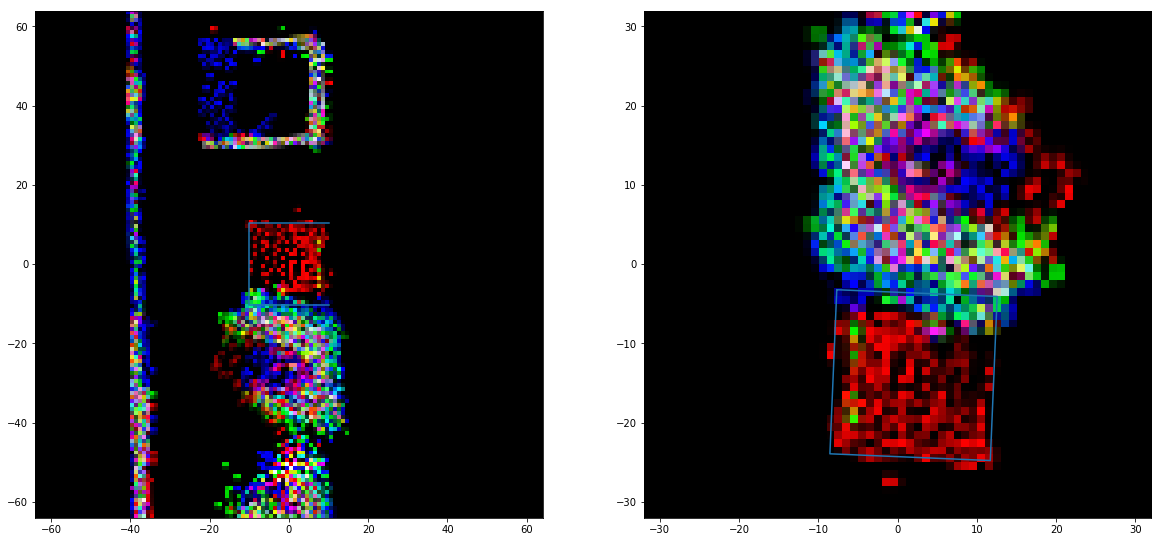

In [316]:
with open(origs[np.random.randint(2000)], 'rb') as handle:
    p = pickle.load(handle)

var = _augment(p, radius=32)

figsize(20,10)
subplot(1,2,1)
imshow(p.volumetric[2:5].transpose(1,2,0),extent=(-64,64,-64,64))
if p.label:
    plot(*p.obb.points().T)


subplot(1,2,2)
imshow(var.volumetric[2:5].transpose(1,2,0), extent=(-32,32,-32,32))
if var.label:
    plot(*var.obb.points()[(0,1,2,3,0),:].T)
    print(var.obb.origin)

In [295]:
# pos
idx = np.random.randint(len(da.posinfo))
# idx = 15

# dx = int(np.random.randn() * C.MAX_OFFSET / METER_PER_PIXEL)
# dy = int(np.random.randn() * C.MAX_OFFSET / METER_PER_PIXEL)
dx, dy = 0, 0
# rotate_angle = np.random.rand() * 360         # or 90? 90 is easier to calculate
rotate_angle = 0
# expected_angle = 
angle, length, width = posinfo[idx,2], posinfo[idx,3], posinfo[idx,4]
cropped_patch = da.get_patch_xyr(posinfo[idx,0], 
                                 posinfo[idx,1], 
                                 dx, 
                                 dy, 
                                 -posinfo[idx, 2] + rotate_angle, 
                                 radius_in_pixels=32)

before = OrientedBoundingBox.from_rot_length_width((0,0), rotate_angle, length, width)
before2 = OrientedBoundingBox.from_rot_length_width((0,0), angle, length, width)

T = affine.Affine.translation(dx, dy)
R = affine.Affine.rotation(rotate_angle)
S = ~affine.Affine.scale(METER_PER_PIXEL)
A = T * R * S # S * R * T
after = np.vstack(A * before.points().T).T
after = OrientedBoundingBox.from_points(after)


figsize(20,20)
subplot(2,2,1)
imshow(cropped_patch[:3].transpose(1,2,0), extent=(-32,32,-32,32))
scatter(*after.points().T)
plot(*after.points()[(0,1,2,3,0),:].T, color='y')
subplot(2,2,2)
imshow(Normalize()(cropped_patch[5:8]).transpose(1,2,0), extent=(-32,32,-32,32),vmax=22, vmin=0)
scatter(*after.points().T)


# original_sample = da.get_patch_xy(posinfo[idx,0], posinfo[idx,1], radius_in_pixels=32)
# pixel_points = np.vstack(S * before2.points().T).T
# subplot(2,2,3)
# imshow(original_sample[:3].transpose(1,2,0), extent=(-32,32,-32,32))
# scatter(*pixel_points.T)
# plot(*pixel_points[(0,1,2,3,0),:].T, color='y')
# subplot(2,2,4)
# imshow(Normalize()(original_sample[5:8]).transpose(1,2,0), extent=(-32,32,-32,32),vmax=22, vmin=0)
# scatter(*pixel_points.T)
# x,y = S*(hotspots[idx]-posinfo[idx,:2]).T
# mark = np.vstack((x,y)).T
# scatter(*mark.T, color='r')

NameError: name 'posinfo' is not defined

In [311]:
def gen_pos_aug_patch(idx, max_offset=C.MAX_OFFSET, max_rot=360):
    
    aug_patch_rot = np.random.rand() * max_rot
    aug_patch_x = np.random.randn() * max_offset
    aug_patch_y = np.random.rand() * max_offset
    
    row = pos_info[idx]
    cropped = get_patch_xyr(row[0], row[1], aug_patch_x, aug_patch_y, row[2]+aug_patch_rot, 32)
    obb = OrientedBoundingBox.from_rot_length_width((row[0], row[1]), row[2], row[3], row[4])
    
    T = affine.Affine.translation(aug_patch_x, aug_patch_y)
    R = affine.Affine.rotation(aug_patch_rot)
    A = ~(T * R)
    
    transformed_box = OrientedBoundingBox.from_points(np.vstack(A *(obb.points().T)).T - np.array((row[0], row[1])))
    
    return Patch(transformed_box, cropped[:3], cropped[3:]), (aug_patch_rot, aug_patch_x, aug_patch_y)
    
    # return new_meta, A
    

In [54]:
from sklearn.model_selection import KFold

The "simple" thing to me is the following:
- we generate files that are all the same size (e.g. 96 by 96)       [_we can totally do this using old code_]
- we keep a record of how each file was generated from the raw input
- we keep a record that tells us what the net should predict when given that small file

In [65]:
kf = KFold(n_splits=C.FOLDS, shuffle=True, random_state=C.FOLD_RANDOM_SEED)

In [66]:
for train_index, test_index in kf.split(hotspots):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    pos_train, pos_test = hotspots[train_index], hotspots[test_index]
    

('TRAIN:', 156, 'TEST:', 40)
('TRAIN:', 157, 'TEST:', 39)
('TRAIN:', 157, 'TEST:', 39)
('TRAIN:', 157, 'TEST:', 39)
('TRAIN:', 157, 'TEST:', 39)
